In [1]:
import os

os.chdir("../..")
import utils

In [2]:
outputfolder = os.getcwd() + '/output/'
datafolder = os.getcwd() + '/datasets/PTB-XL/'
sampling_rate = 100
task = 'subdiagnostic'
experiment_name = 'exp1.1'

In [3]:
data, raw_labels = utils.load_dataset(datafolder, sampling_rate=sampling_rate)
labels = utils.compute_label_aggregations(raw_labels, datafolder, task)
data, labels, Y, _ = utils.select_data(data, labels, task, 0, outputfolder+experiment_name+'/data/')

In [4]:
X_test = data[labels.strat_fold == 10]
y_test = Y[labels.strat_fold == 10]

X_val = data[labels.strat_fold == 9]
y_val = Y[labels.strat_fold == 9]

X_train = data[labels.strat_fold <= 8]
y_train = Y[labels.strat_fold <= 8]

n_classes = y_train.shape[1]

print(f"This experiment has {n_classes} classes")

This experiment has 23 classes


In [5]:
X_train_lead1 = X_train[:,:,0]
X_test_lead1 = X_test[:,:,0]
X_val_lead1 = X_val[:,:,0]

## One from the paper

In [20]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Add, MaxPooling1D, GlobalAveragePooling1D, Dense

def residual_block(x, filters, kernel_size=3, stride=1):
    y = Conv1D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = Conv1D(filters, kernel_size=kernel_size, strides=1, padding='same')(y)
    y = BatchNormalization()(y)

    if stride > 1:
        x = Conv1D(filters, kernel_size=1, strides=stride, padding='same')(x)

    out = Add()([x, y])
    out = Activation('relu')(out)
    return out

input_layer = Input(shape=(1000, 12))

# Initial Convolutional Layer
x = Conv1D(64, kernel_size=7, strides=2, padding='same')(input_layer)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Residual Blocks
for _ in range(3):
    x = residual_block(x, filters=64)

# Global Average Pooling and Dense Layer
x = GlobalAveragePooling1D()(x)
output_layer = Dense(23, activation='softmax')(x)  # Assuming 5 output classes

resnet1d_model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

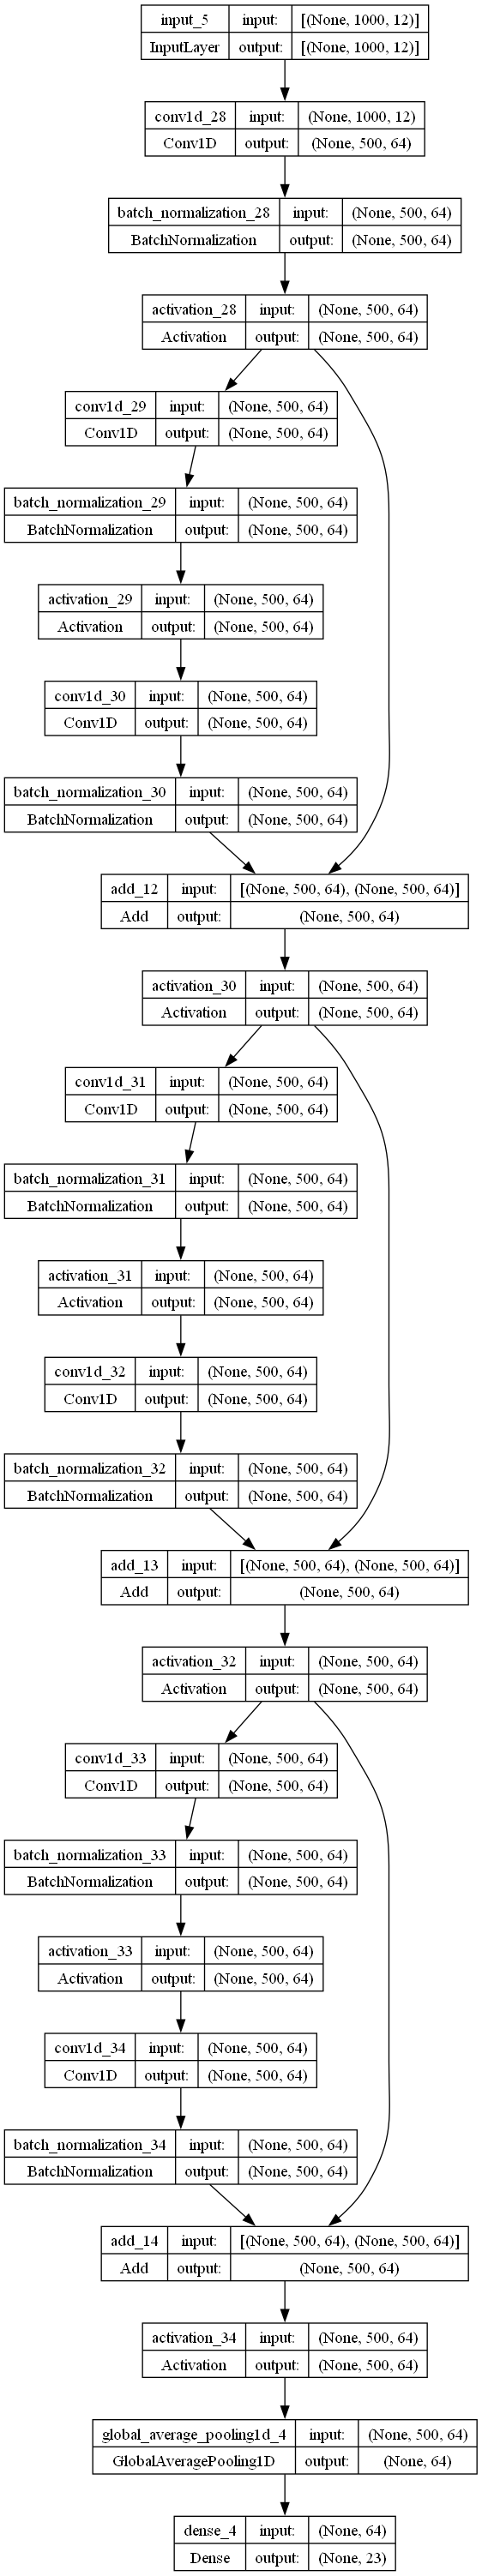

In [25]:
plot_model(resnet1d_model, show_shapes=True)

In [27]:
resnet1d_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy',threshold=0.5),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(num_thresholds=200,
                                curve="ROC",
                                summation_method='interpolation',
                                name="AUC",
                                multi_label=True,
                                label_weights=None)])

In [28]:
resnet1d_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)

Epoch 1/50
534/534 [==============================] - 82s 145ms/step - loss: 0.1248 - accuracy: 0.9549 - recall: 0.3685 - AUC: 0.7692 - val_loss: 0.1605 - val_accuracy: 0.9511 - val_recall: 0.4073 - val_AUC: 0.7330
Epoch 2/50
534/534 [==============================] - 84s 158ms/step - loss: 0.1082 - accuracy: 0.9595 - recall: 0.4404 - AUC: 0.7999 - val_loss: 0.1099 - val_accuracy: 0.9589 - val_recall: 0.4513 - val_AUC: 0.7844
Epoch 3/50
534/534 [==============================] - 112s 210ms/step - loss: 0.1026 - accuracy: 0.9607 - recall: 0.4590 - AUC: 0.8115 - val_loss: 0.1082 - val_accuracy: 0.9588 - val_recall: 0.4593 - val_AUC: 0.7956
Epoch 4/50
534/534 [==============================] - 113s 211ms/step - loss: 0.0984 - accuracy: 0.9612 - recall: 0.4675 - AUC: 0.8296 - val_loss: 0.1051 - val_accuracy: 0.9601 - val_recall: 0.4546 - val_AUC: 0.8195
Epoch 5/50
534/534 [==============================] - 119s 223ms/step - loss: 0.0952 - accuracy: 0.9619 - recall: 0.4760 - AUC: 0.8331 - v

KeyboardInterrupt: 

In [32]:
preds = resnet1d_model.predict(X_test)

from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, preds)

68/68 [==============================] - 9s 133ms/step


0.889883955705416

single lead model

In [33]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Add, MaxPooling1D, GlobalAveragePooling1D, Dense

def residual_block(x, filters, kernel_size=3, stride=1):
    y = Conv1D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = Conv1D(filters, kernel_size=kernel_size, strides=1, padding='same')(y)
    y = BatchNormalization()(y)

    if stride > 1:
        x = Conv1D(filters, kernel_size=1, strides=stride, padding='same')(x)

    out = Add()([x, y])
    out = Activation('relu')(out)
    return out

input_layer = Input(shape=(1000, 1))

# Initial Convolutional Layer
x = Conv1D(64, kernel_size=7, strides=2, padding='same')(input_layer)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Residual Blocks
for _ in range(3):
    x = residual_block(x, filters=64)

# Global Average Pooling and Dense Layer
x = GlobalAveragePooling1D()(x)
output_layer = Dense(23, activation='softmax')(x)  # Assuming 5 output classes

resnet1d_model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

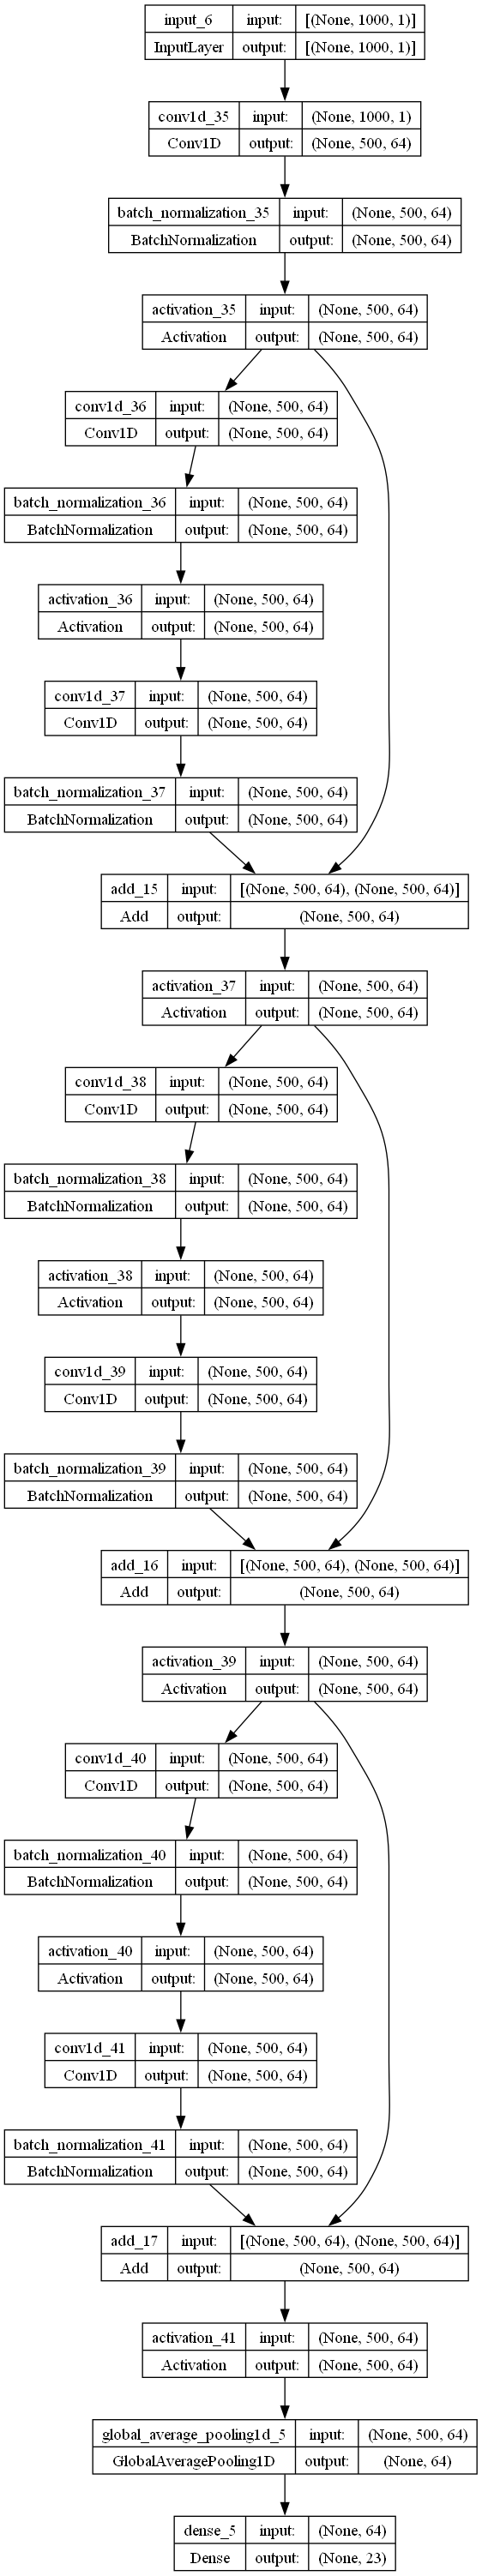

In [34]:
plot_model(resnet1d_model, show_shapes=True)

In [49]:
resnet1d_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy',threshold=0.5),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(num_thresholds=200,
                                curve="ROC",
                                summation_method='interpolation',
                                name="AUC",
                                multi_label=True,
                                label_weights=None)])

In [37]:
# resnet1d_model.fit(X_train_lead1, y_train, validation_data=(X_val_lead1, y_val), epochs=20, batch_size=32)

Epoch 1/20
534/534 [==============================] - 164s 290ms/step - loss: 0.1583 - accuracy: 0.9472 - recall: 0.2490 - AUC: 0.7017 - val_loss: 0.1623 - val_accuracy: 0.9474 - val_recall: 0.3185 - val_AUC: 0.7510
Epoch 2/20
534/534 [==============================] - 109s 204ms/step - loss: 0.1447 - accuracy: 0.9495 - recall: 0.2796 - AUC: 0.7504 - val_loss: 0.1485 - val_accuracy: 0.9506 - val_recall: 0.2868 - val_AUC: 0.7346
Epoch 3/20
534/534 [==============================] - 108s 202ms/step - loss: 0.1403 - accuracy: 0.9501 - recall: 0.2902 - AUC: 0.7672 - val_loss: 0.1511 - val_accuracy: 0.9495 - val_recall: 0.3245 - val_AUC: 0.7368
Epoch 4/20
534/534 [==============================] - 107s 200ms/step - loss: 0.1382 - accuracy: 0.9502 - recall: 0.2904 - AUC: 0.7781 - val_loss: 0.1445 - val_accuracy: 0.9489 - val_recall: 0.3328 - val_AUC: 0.7486
Epoch 5/20
534/534 [==============================] - 108s 202ms/step - loss: 0.1360 - accuracy: 0.9505 - recall: 0.2957 - AUC: 0.7857 -

In [50]:
history = resnet1d_model.fit(X_train_lead1, y_train, validation_data=(X_val_lead1, y_val), epochs=20, batch_size=32)

history.history

Epoch 1/20
534/534 [==============================] - 130s 233ms/step - loss: 0.1213 - accuracy: 0.9531 - recall: 0.3356 - AUC: 0.8428 - val_loss: 0.1418 - val_accuracy: 0.9508 - val_recall: 0.3517 - val_AUC: 0.7827
Epoch 2/20
534/534 [==============================] - 120s 224ms/step - loss: 0.1207 - accuracy: 0.9533 - recall: 0.3387 - AUC: 0.8412 - val_loss: 0.1347 - val_accuracy: 0.9514 - val_recall: 0.3321 - val_AUC: 0.7873
Epoch 3/20
534/534 [==============================] - 113s 212ms/step - loss: 0.1201 - accuracy: 0.9534 - recall: 0.3415 - AUC: 0.8428 - val_loss: 0.1361 - val_accuracy: 0.9516 - val_recall: 0.3305 - val_AUC: 0.7926
Epoch 4/20
534/534 [==============================] - 118s 220ms/step - loss: 0.1195 - accuracy: 0.9533 - recall: 0.3396 - AUC: 0.8453 - val_loss: 0.1418 - val_accuracy: 0.9509 - val_recall: 0.3341 - val_AUC: 0.7975
Epoch 5/20
534/534 [==============================] - 125s 235ms/step - loss: 0.1190 - accuracy: 0.9534 - recall: 0.3412 - AUC: 0.8465 -

{'loss': [0.12126091867685318,
  0.12071893364191055,
  0.12012263387441635,
  0.11951247602701187,
  0.11900874227285385,
  0.11874891072511673,
  0.11800429970026016,
  0.11746473610401154,
  0.1171020120382309,
  0.11611677706241608,
  0.1155611053109169,
  0.11454945802688599,
  0.11409562826156616,
  0.11303629726171494,
  0.11242362856864929,
  0.11169124394655228,
  0.11083662509918213,
  0.1099851205945015,
  0.10961777716875076,
  0.10819866508245468],
 'accuracy': [0.9530503749847412,
  0.9532667398452759,
  0.9533710479736328,
  0.9532565474510193,
  0.9533812403678894,
  0.9534245133399963,
  0.9536408185958862,
  0.9537197351455688,
  0.9536738991737366,
  0.9539182186126709,
  0.9540785551071167,
  0.954391598701477,
  0.9542770981788635,
  0.9547834992408752,
  0.9548318982124329,
  0.9550762176513672,
  0.9550889134407043,
  0.9551500082015991,
  0.9554910063743591,
  0.955926239490509],
 'recall': [0.3356461524963379,
  0.338743656873703,
  0.3415107727050781,
  0.3395

In [39]:
preds = resnet1d_model.predict(X_test_lead1)

roc_auc_score(y_test, preds)

68/68 [==============================] - 3s 45ms/step


0.842946560320736

In [42]:
import matplotlib.pyplot as plt
model = resnet1d_model

plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['AUC'])
plt.plot(model.history.history['val_accuracy'])
plt.plot(model.history.history['val_AUC'])
plt.legend(("accuracy","auc", "val_accuracy", "val_auc"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

KeyError: 'accuracy'

In [47]:
model.history